# Time Series Forecasting with SARIMA Model

## Introduction

In this experiment, we will use the dataset of [Climate Change: Earth Surface Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data).

The dataset contains the global land and ocean temperature data from 1750 to 2015. The data is divided into 7 files, and I will mainly use the GlobalLandTemperaturesByCountry and City data.

The main practice on this dataset will be:
1. Data Preprocessing using **Polars** library
2. **Seasonal ARIMA (SARIMA)** model for time series forecasting


In [125]:
# library import
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

import os
import re
import glob
import shutil
import gc
from pathlib import Path
import xlsxwriter

# showing module
from IPython.display import display

# output display option adjustment
# precision of floating point in numpy
np.set_printoptions(suppress=True, precision=4)

# precision of floating point in pandas
pd.options.display.float_format = '{:.4f}'.format

# display all columns in dataframe
pd.set_option("display.max_columns",None)

# default font size in graph
plt.rcParams["font.size"] = 14

# graph display
sns.set(rc={'figure.figsize':(12,5)})

# random seed
random_seed = 49

[Climate Change: Earth Surface Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data)

In [2]:
# create the input_dir（input directory）
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# if INPUT_DIR has not been created yet, create it
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) creation
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# if OUTPUT_DIR has not been created yet, create it
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [3]:
# Once you run this code, comment it out
# move csv files to `data` directory(=folder)
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*.csv'):
#     unique_dir_names.append(f)

# for file in list(set(unique_dir_names)):
#     print(f'moved file: {file}')
#     shutil.move(f'{file}', f'{INPUT_DIR}')

In [4]:
# Polars function to let us read csv files without having to specify the directory
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.csv')
    print(f'Load: {path}')
    return pl.read_csv(path, **kwrgs)

In [5]:
df_state = read_csv("GlobalLandTemperaturesByState")
df_city = read_csv("GlobalLandTemperaturesByCity")

Load: /Users/satoshiido/Documents/programming/climate-change-analysis/data/GlobalLandTemperaturesByState.csv
Load: /Users/satoshiido/Documents/programming/climate-change-analysis/data/GlobalLandTemperaturesByCity.csv


In [6]:
def display_data_info(df_state, df_city):
    display(df_state.shape)
    display(df_city.shape)
    display(df_state.null_count())
    display(df_city.null_count())
    display(df_state[["Country", "AverageTemperature"]].group_by(["Country"]).mean().sort("AverageTemperature"))
    display(df_city[["Country", "AverageTemperature"]].group_by(["Country"]).mean().sort("AverageTemperature"))

display_data_info(df_state, df_city)

(645675, 5)

(8599212, 7)

dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
u32,u32,u32,u32,u32
0,25648,25648,0,0


dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
u32,u32,u32,u32,u32,u32,u32
0,364130,364130,0,0,0,0


Country,AverageTemperature
str,f64
"""Canada""",-1.321079
"""Russia""",1.808555
"""United States""",10.701555
"""China""",11.20683
"""Australia""",17.664222
"""India""",22.534576
"""Brazil""",23.770601


Country,AverageTemperature
str,f64
"""Mongolia""",-3.365485
"""Iceland""",1.500089
"""Russia""",3.347268
"""Norway""",3.612553
"""Finland""",3.711645
"""Kazakhstan""",4.3403
"""Estonia""",4.695705
"""Canada""",4.900387
"""Latvia""",5.386616


## Preprocessing

In [7]:
df_state = read_csv("GlobalLandTemperaturesByState")
df_city = read_csv("GlobalLandTemperaturesByCity")

Load: /Users/satoshiido/Documents/programming/climate-change-analysis/data/GlobalLandTemperaturesByState.csv
Load: /Users/satoshiido/Documents/programming/climate-change-analysis/data/GlobalLandTemperaturesByCity.csv


In [8]:
df_state = df_state.rename({"dt": "date", "AverageTemperature": "avg_temp", "AverageTemperatureUncertainty": "avg_temp_uncertainty", "State": "state", "Country": "country"})
df_city = df_city.rename({"dt": "date", "AverageTemperature": "avg_temp", "AverageTemperatureUncertainty": "avg_temp_uncertainty", "City":"city", "Country": "country"})

In [9]:
df_state = (df_state.with_columns(pl.col("date").str.strptime(pl.Datetime).set_sorted()))
df_city = (df_city.with_columns(pl.col("date").str.strptime(pl.Datetime).set_sorted()))

In [10]:
df_state = df_state.with_columns(pl.col("date").dt.year().alias("Year"))

In [11]:
# fill null values with the average temperature of the previous and next values
df_state = df_state.with_columns([
    pl.col("avg_temp").forward_fill().alias("ffill"),
    pl.col("avg_temp").backward_fill().alias("bfill")
])
avg_fill = (pl.col("ffill") + pl.col("bfill")) / 2
df_state = df_state.with_columns(avg_fill = (pl.col("ffill") + pl.col("bfill")) / 2)
df_state = df_state.with_columns(avg_temp = pl.when(pl.col("avg_temp").is_null()).then(pl.col("avg_fill")).otherwise(pl.col("avg_temp")))
df_state = df_state.drop(["ffill", "bfill", "avg_fill"])

In [12]:
# Exctract the latest data from 1970
latest_state = df_state.filter(pl.col("Year") > 1970)
latest_state.head()

date,avg_temp,avg_temp_uncertainty,state,country,Year
datetime[μs],f64,f64,str,str,i32
1971-01-01 00:00:00,25.842,0.266,"""Acre""","""Brazil""",1971
1971-02-01 00:00:00,25.325,0.42,"""Acre""","""Brazil""",1971
1971-03-01 00:00:00,25.866,0.164,"""Acre""","""Brazil""",1971
1971-04-01 00:00:00,25.312,0.191,"""Acre""","""Brazil""",1971
1971-05-01 00:00:00,24.859,0.547,"""Acre""","""Brazil""",1971


## Plotting

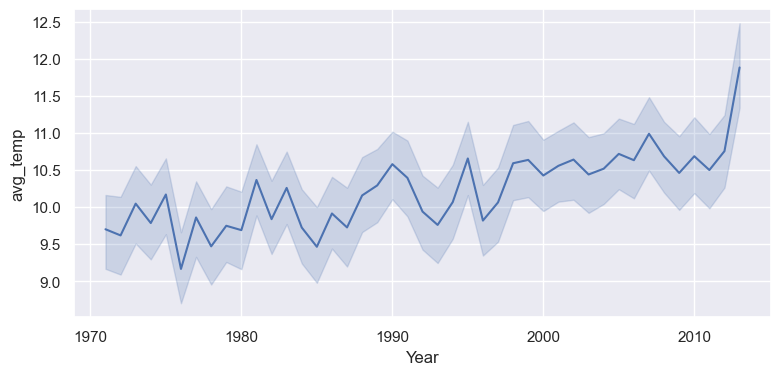

In [13]:
plt.figure(figsize=(9,4))
sns.lineplot(x="Year", y="avg_temp", data=latest_state)
plt.show()

## Special Mean and S.D

Rolling Mean and S.D. of Temperature and EWMA

In [14]:
# calculate the rolling average of the 2 months
## sort the data by date and set the sorted index to date
latest_state = latest_state.sort("date").set_sorted("date")

latest_state = latest_state.with_columns(
    # rolling average of 2 months
    rol_avg_temp_2 = pl.mean("avg_temp").rolling(index_column="date", period="2mo"),
    # exponentially weighted mean (EWMA) with a span of 3
    ewm_3 = pl.col("avg_temp").ewm_mean(span=3),
    # exponentially weighted standard deviation (EWMA) with a span of 3
    rol_std_3 = pl.col("avg_temp").ewm_std(span=3)
)

In [15]:
# calculate the year rolling (2months) average temperature
latest_state_by_year = latest_state.group_by("Year").agg(
    pl.col("avg_temp").mean().alias("avg_temp"),
    pl.col("rol_avg_temp_2").mean().alias("rol_avg_temp_2"),
    pl.col("ewm_3").mean().alias("ewm_3"),
    pl.col("rol_std_3").mean().alias("rol_std_3")
)

In [20]:
latest_state_by_year.head()

Year,avg_temp,rol_avg_temp_2,ewm_3,rol_std_3
i32,f64,f64,f64,f64
1971,9.70175,9.645251,9.706589,9.392597
1972,9.618741,9.607007,9.618557,9.757917
1973,10.047222,10.05357,10.04756,9.40424
1974,9.78556,9.795287,9.785161,9.556397
1975,10.170493,10.180059,10.171376,9.252543


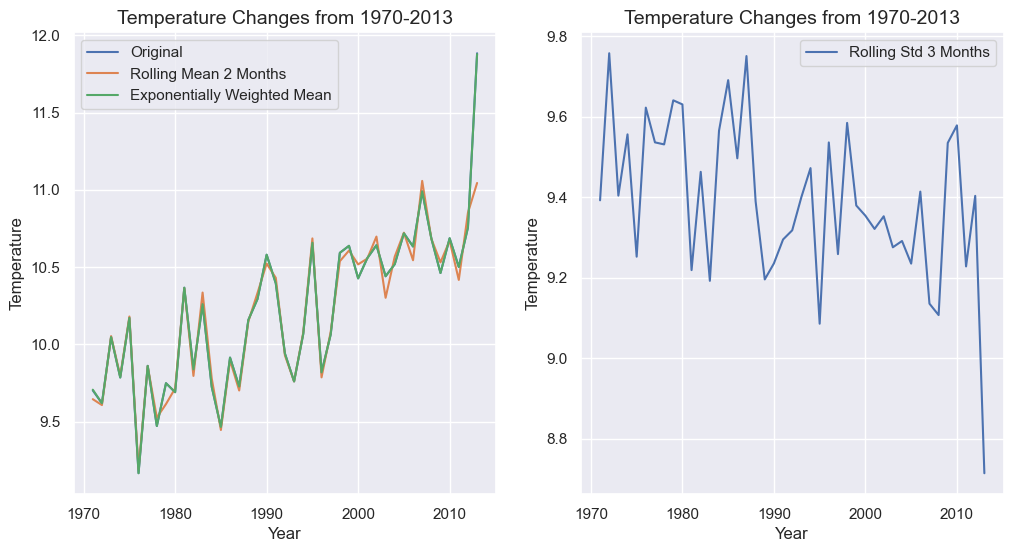

In [17]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
latest_state_by_year = latest_state_by_year.sort("Year")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(latest_state_by_year["Year"], latest_state_by_year["avg_temp"], label="Original")
ax1.plot(latest_state_by_year["Year"], latest_state_by_year["rol_avg_temp_2"], label="Rolling Mean 2 Months")
ax1.plot(latest_state_by_year["Year"], latest_state_by_year["ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Temperature Changes from 1970-2013", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("Temperature", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(latest_state_by_year["Year"], latest_state_by_year["rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Temperature Changes from 1970-2013", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("Temperature", fontsize = 12)
ax2.legend()

## Time Series Modeling

I apply SARIMA model to the temperature data especially for the city of New York.

In [79]:
# preprocessing for the analysis
start_date = datetime(1990, 1, 1)
end_date = datetime(2012, 12, 31)

# filter the data for New York and select the date and average temperature
# Also, filter the data for the specified date range (1990-2012)
ny = df_city.filter((pl.col("city") == "New York")
    ).select(pl.col("date"), pl.col("avg_temp").alias("Temp")
    ).filter((pl.col("date") >= start_date) & (pl.col("date") <= end_date))

# change theb data frqeuency to monthly and fill the null values with the previous value
ny = ny.upsample(
    time_column="date", every="1mo", maintain_order=True
    ).with_columns((pl.col("Temp").backward_fill(limit=1)))

ny.head()

date,Temp
datetime[μs],f64
1990-01-01 00:00:00,1.536
1990-02-01 00:00:00,1.236
1990-03-01 00:00:00,4.973
1990-04-01 00:00:00,9.563
1990-05-01 00:00:00,13.983


In the following section, I'll provide a concise overview of ARIMA models:

# <font color=lightblue>SARIMA Model (p, d, q)(P, D, Q, S)</font>:
SARIMA is an acronym for Seasonal AutoRegressive Integrated Moving Average. Despite its intimidating name, the concept is more approachable than it first appears.

## <font color=lightblue>Non-Seasonal ARIMA (p, d, q)(P, D, Q, S)</font>:

The term ARIMA is divided into three components: AR, I, and MA:

- **AR(p)**: This stands for the *autoregressive* part, where `p` is an integer indicating the count of lagged observations included in the model. For instance:
    - The average temperature from the previous day greatly influences today's temperature; hence we use AR(1) to predict future temperatures.
    - The AR(p) model is represented by the equation: $\hat{y}_{t} = \mu + \theta_{1}Y_{t-1} + ... + \theta_{p}Y_{t-p}$, where $\mu$ is a constant, **p** denotes the number of lag periods, and $\theta$ represents the fitted parameter.

- **I(d)**: This represents the *differencing* step, with `d` indicating the number of differencing operations applied to achieve stationarity. For example:
    - If we sold 10 items yesterday and 14 today, the first difference (I) is +4. If using logs, this signifies a percentage change.
    - For d = 1: $y_{t} = Y_{t} - Y_{t-1}$
    - For d = 2: $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-1} - Y_{t-2})$
    - The second difference evaluates the rate of change, providing insight into acceleration rather than just trend.

- **MA(q)**: This refers to the *moving average* component, where `q` is the number of lagged forecast errors in the prediction equation. For example:
    - The MA term incorporates a fraction of past forecasting errors, postulating that these errors will recur in future forecasts.
    - The MA(q) model is defined as: $\hat{y}_{t} = \mu - \Theta_{1}e_{t-1} + ... + \Theta_{q}e_{t-q}$, where $\mu$ is the constant, **q** refers to the lag period for the error term $e$, and $\Theta$ is the parameter fitted to these errors.
    - The error term is calculated by $ e_{t} = Y_{t-1} - \hat{y}_{t-1}$.


# <font color=lightblue>Seasonal ARIMA (p, d, q)(P, D, Q, S)</font>:

The seasonal parameters **P, D, Q** are capitalized to differentiate them from the non-seasonal parameters.

- **SAR(P)**: This is the seasonal autoregressive term.
    - The SAR(P) model equation is: $\hat{y}_{t} = \mu + \theta_{1}Y_{t-s}$, where P is the number of autoregressive terms included, s denotes the seasonal lag, and $\theta$ is the parameter fitted to the data.
    - In weather forecasting, data from 12 months prior can be informative for the current period.
    - Opting for SAR(1) incorporates a factor of $Y_{t-s}$ into the forecast for $y_{t}$.

- **I(D)**: Seasonal differencing is essential when there's a pronounced, consistent pattern.
    - With d = 0 and D = 1: $y_{t} = Y_{t} - Y_{t-s}$
    - With d = 1 and D = 1: $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-s} - Y_{t-s-1})$
    - D should not exceed 1, and the sum of d+D should not be more than 2. If d+D equals 2, the constant term is typically omitted.

- **SMA(Q)**: 
    - Setting Q=1, for example as SMA(1), incorporates a multiple of the error term $e_{t-s}$ into the forecast for $y_{t}$.

- **S**: This denotes the seasonal period for calculating P, D, Q. For instance, a 52-week seasonal pattern would be represented by 'S'.

# <font color=lightblue>Trend (p, d, q)(P, D, Q, S)</font>:

To predict trends, we use [SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). The following notations define the trend components:

- 'n' implies no trend (default).
- 'c' signifies aconstant term in the model.
- 't' stands for a linear trend over time.
- 'ct' combines both a constant and a linear trend.
- A custom polynomial trend can also be specified, akin to `numpy.poly1d`, for example, [1,1,0,1] would denote a trend of the form a+bt+ct³.

Briefly check the variation of temperature in New York from 1900 to 2012.

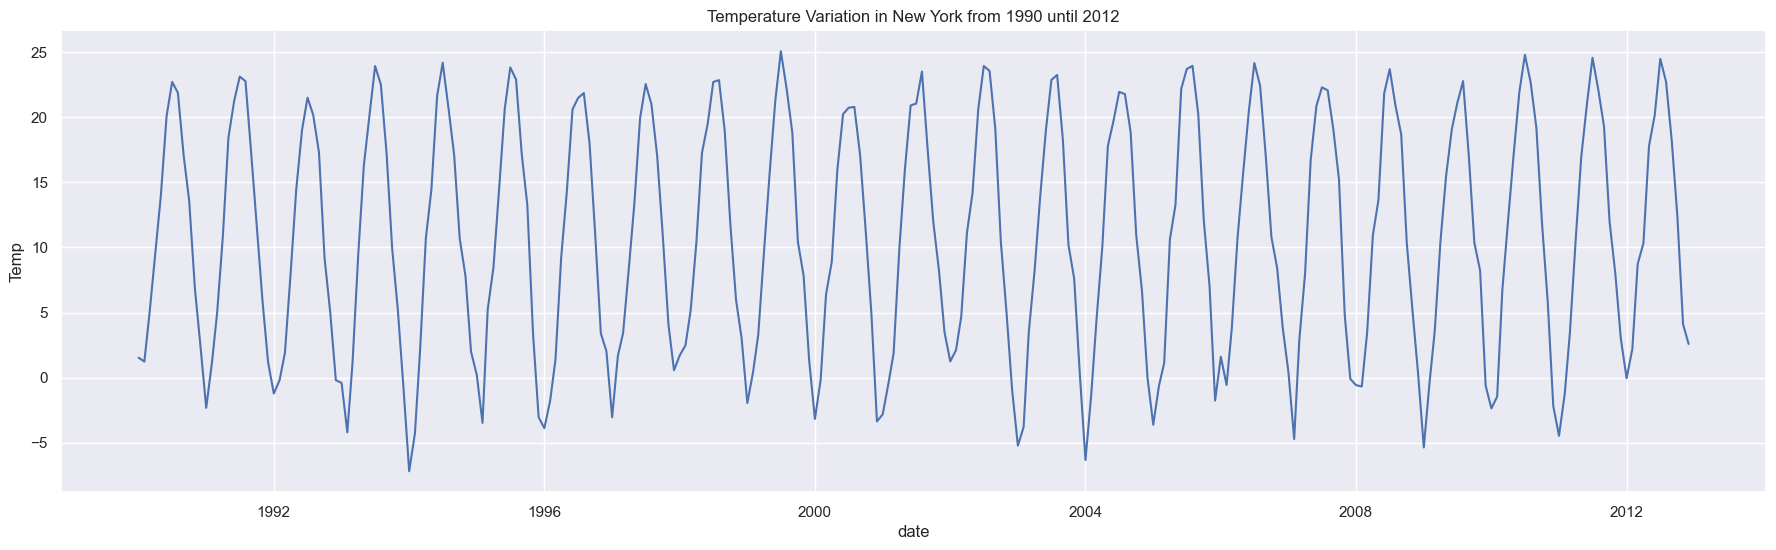

In [78]:
plt.figure(figsize=(22,6))
sns.lineplot(data=ny,
             x="date", y="Temp").set(title="Temperature Variation in New York from 1990 until 2012")

plt.show()


From these plots, we can see that the temperature has some seasonality. From April to September, the temperature is higher than the rest of the year. The temperature also has an increasing trend over time.

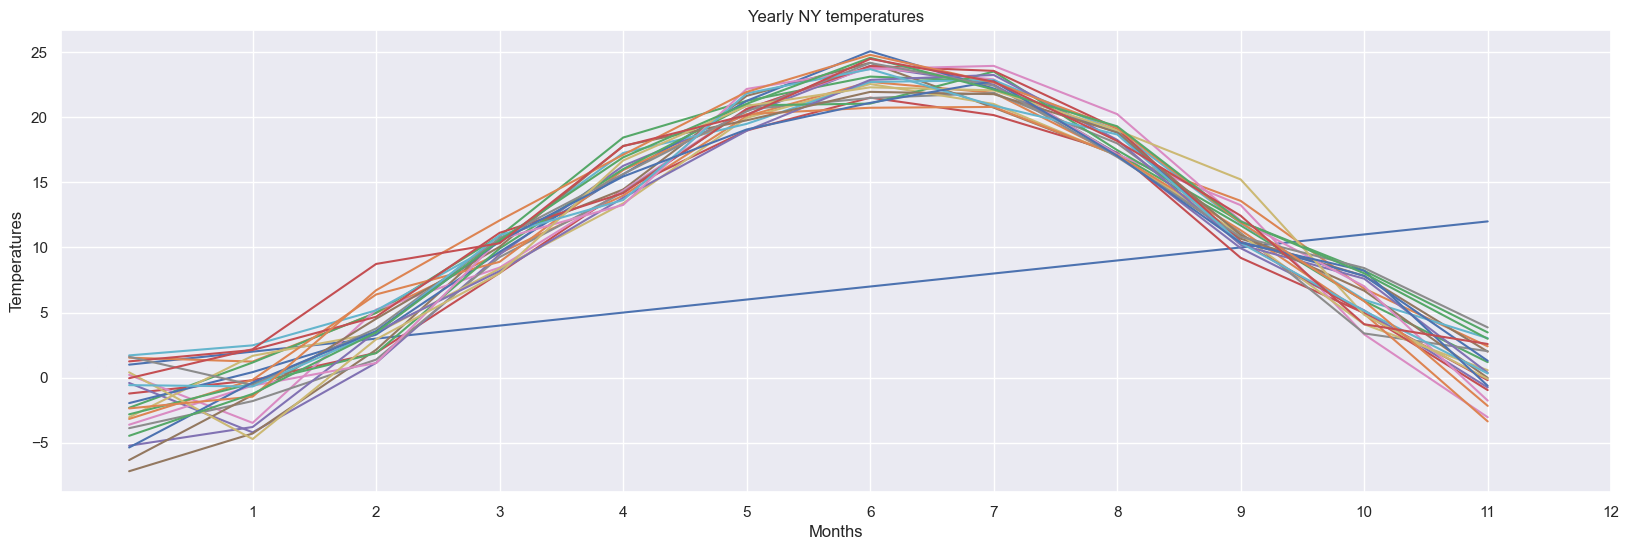

In [91]:
ny = ny.with_columns(pl.col("date").dt.month().alias("month"), pl.col("date").dt.year().alias("year"))
pivot_ny = ny.pivot(index="month", columns="year", values="Temp", aggregate_function="mean")
pivot_ny_pd = pivot_ny.to_pandas()
pivot_ny_pd.plot(figsize=(20,6))
plt.title('Yearly NY temperatures')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

### Data Split

Before proceeding, I will split the data into training, validation and test sets. After training the model, I will use the last 5 years for validation and testing, with 48 months for month-by-month walk-forward validation and 12 months for future extrapolation to compare against the test set.

In [97]:
train = ny[:60].clone()
val = ny[60:-12].clone()
test = ny[-12:].clone()
train.shape, val.shape, test.shape

((60, 4), (204, 4), (12, 4))

And before creating the forecasts we will create a baseline forecast in the validation set, in our simulation we will try to have a smaller error compared to this one.

it will hold the previous month as a base forecast to the next month:

In [104]:
train[-1:]

date,Temp,month,year
datetime[μs],f64,u32,i32
1994-12-01 00:00:00,1.999,12,1994


In [108]:
jan_avg_temp = train.filter(pl.col("month") == 1).tail().mean().select(pl.col("Temp"))
jan_avg_temp

Temp
f64
-1.9162


In [116]:
# fill the first row of the validation with average temeprature of January in the five year before
jan_avg_temp = train.filter(pl.col("month") == 1).tail().mean().select(pl.col("Temp"))

baseline = val['Temp'].shift(fill_value=jan_avg_temp.item())
# baseline.dropna(inplace=True)
baseline.head()

Temp
f64
-1.9162
0.214
-3.47
5.229
8.455
14.357
20.644
23.823
22.905


We create a function to use the [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) as a base to calculate the error of the forecast.

In [126]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val.select(pl.col("Temp")), baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 5.0 celsius degrees


As we can see, the series has a small uptrend and it appears that there is some seasonality with higher temperatures at the begining and end of the year and lower temperatures around the middle of the year.

To create a time series forecast, the series must be stationary (constant mean, variance and autocorrelation).

One way to check if the series is stationary is using the **adfuller function**, if the P-Value is lower than 5% (usual number used for this kind of study) the series is stationary and we can start creating our model. 

If the series isn't stationary we can do some data transformation like using natural logarithm, deflation, differencing, etc.

Below is the function that can be used to check the stationarity, it plots: 

 * The series itself;
 * The autocorrelation function **(ACF)**:
      * It shows the correlation between the current temperatures versus the lagged versions of itself.
 * The partial autocorrelation **(PACF)**:
     * It shows the correlation between the current temperatures versus the lagged version excluding the effects of earlier lags, for example, it show the effective influence of the lag 3 in the current temperatures excluding the effects of the lags 1 and 2.

For more interesting sources we can read the materials on this amazing website made by Mr. Robert Nau: [ Duke University](http://people.duke.edu/~rnau/411home.htm), also we can check [Jason Brownlee's](machinelearningmastery.com) website, which have a lot of time series content.